In [2]:
import pandas as pd
import sklearn.model_selection as skm
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import GridSearchCV
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeRegressor as DTR
from sklearn.tree import plot_tree
from matplotlib.pyplot import subplots
from sklearn.ensemble import GradientBoostingRegressor as GBR
from sklearn.ensemble import RandomForestRegressor as RF
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

In [3]:
df = pd.read_excel('Lending Club.xlsx')
df = df.dropna()

In [4]:
dummies = pd.get_dummies(df[['Home', 'emp_length']])

y = df['Loan_rate']

# Drop the column with the independent variable (Loan_rate), and columns for which we created dummy variables
X_ = df.drop(['Loan_rate', 'Home', 'emp_length'], axis=1).astype('float64')

# Define the feature set X. Reference group for emp_length is <1 year. Reference group for Home is 'own'.
X = pd.concat([X_, dummies[['emp_length_1 year', 'emp_length_10+ years', 'emp_length_2 years', 'emp_length_3 years', 'emp_length_4 years', 'emp_length_5 years',
'emp_length_6 years', 'emp_length_7 years', 'emp_length_8 years', 'emp_length_9 years', 'Home_MORTGAGE', 'Home_RENT']]], axis=1).astype(float)

X.columns

Index(['Loan_amt', 'Loan_term', 'Income_source_verified', 'Income_verified',
       'Income_thou', 'Debt_income', 'delinq_2yrs', 'Credit_history_length',
       'FICO', 'open_acc', 'Derogatory_recs', 'Revol_balance', 'Revol_util',
       'emp_length_1 year', 'emp_length_10+ years', 'emp_length_2 years',
       'emp_length_3 years', 'emp_length_4 years', 'emp_length_5 years',
       'emp_length_6 years', 'emp_length_7 years', 'emp_length_8 years',
       'emp_length_9 years', 'Home_MORTGAGE', 'Home_RENT'],
      dtype='object')

In [5]:
# Split into training and test sets
X_train, X_test , y_train, y_test = skm.train_test_split(X, y, test_size=0.2, random_state=1)

## KNN

In [5]:
# Define a range for N
param_grid = {
    'n_neighbors': range(5, 200), 
}

# standardize X_train and X_test
scaler = StandardScaler(with_mean=True, with_std=True)
scaler.fit(X_train)
X_train_std=scaler.transform(X_train)

scaler2 = StandardScaler(with_mean=True, with_std=True)
scaler2.fit(X_test)
X_test_std=scaler.transform(X_test)

# Cross-validation to find the best N
cv = GridSearchCV(KNeighborsRegressor(), param_grid, cv=5)

cv.fit(X_train_std, y_train)

print(cv.best_params_)

# refit and find test MSE
KNN = KNeighborsRegressor(n_neighbors=cv.best_params_['n_neighbors'])
KNN.fit(X_train_std, y_train)
y_hat_KNN = KNN.predict(X_test_std)
MSE_KNN = np.mean((y_test - y_hat_KNN)**2)
print(MSE_KNN)

{'n_neighbors': 19}
11.457131324488508


## Decision Tree

### Regression Tree

In [6]:
# fit a decision tree
reg = DTR(random_state=0, max_depth=10) 
reg.fit(X_train, y_train)
MSE_Regression_Tree = np.mean((y_test - reg.predict(X_test))**2)

# Print test MSE
MSE_Regression_Tree

12.633312900342679

##### Regression Tree has higher MSE than linear regression with or without regularization

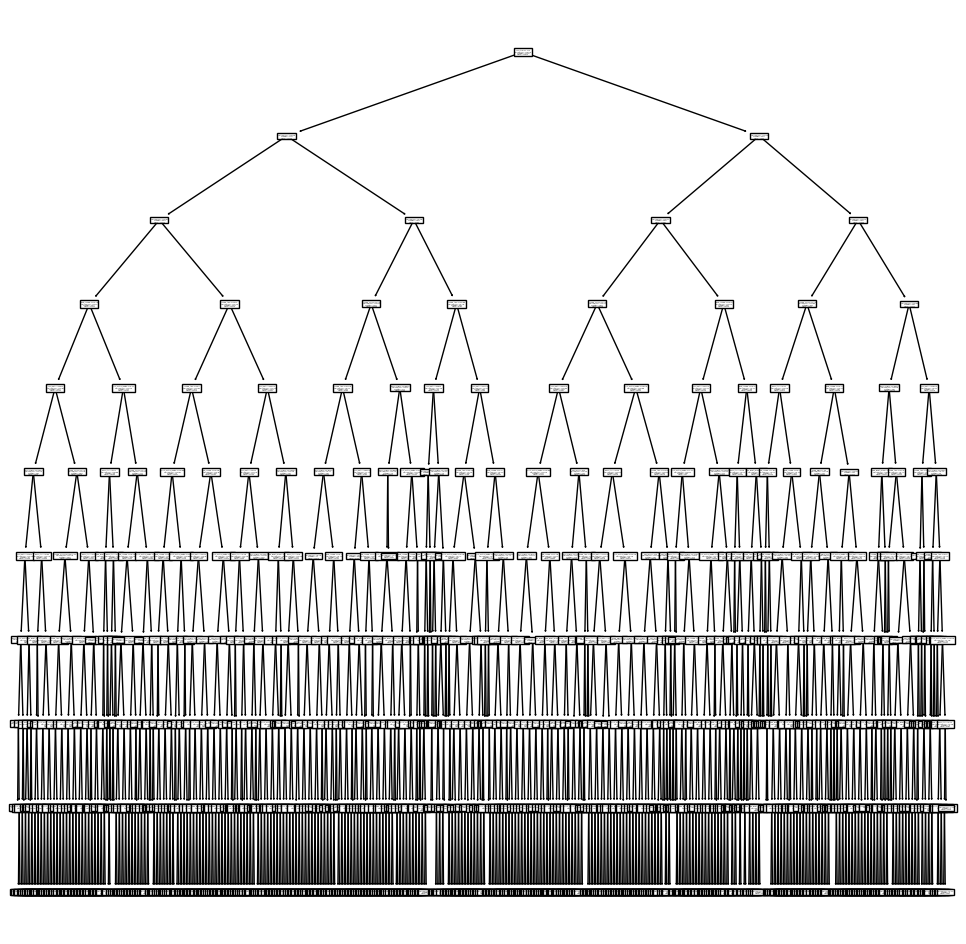

In [7]:
# plot the tree
ax = subplots(figsize=(12,12))[1] 
feature_names = list(X_train.columns)

plot_tree(reg, 
          feature_names=feature_names, 
          ax=ax);

### Pruning

##### Because of the number of features available and the complexity of regression tree, it is likely that we can prune the tree to avoid overfitting and improve out-of-sample test.

In [14]:
# Cross-validation to find tunning parameter
ccp_path = reg.cost_complexity_pruning_path(X_train, y_train) 

kfold = skm.KFold(5,
                  shuffle=True,
                  random_state=0) 

grid = skm.GridSearchCV(reg,
                        {'ccp_alpha': ccp_path.ccp_alphas},
                        refit=True,
                        cv=kfold, 
                        scoring='neg_mean_squared_error')

G = grid.fit(X_train, y_train)
print(grid.best_estimator_.ccp_alpha)

0.028855624001413394


In [15]:
# refit and print test MSE
best_ = grid.best_estimator_
MSE_pruned_tree = np.mean((y_test - best_.predict(X_test))**2)
MSE_pruned_tree

11.245174098875857

##### The test MSE after pruning gives us a better MSE

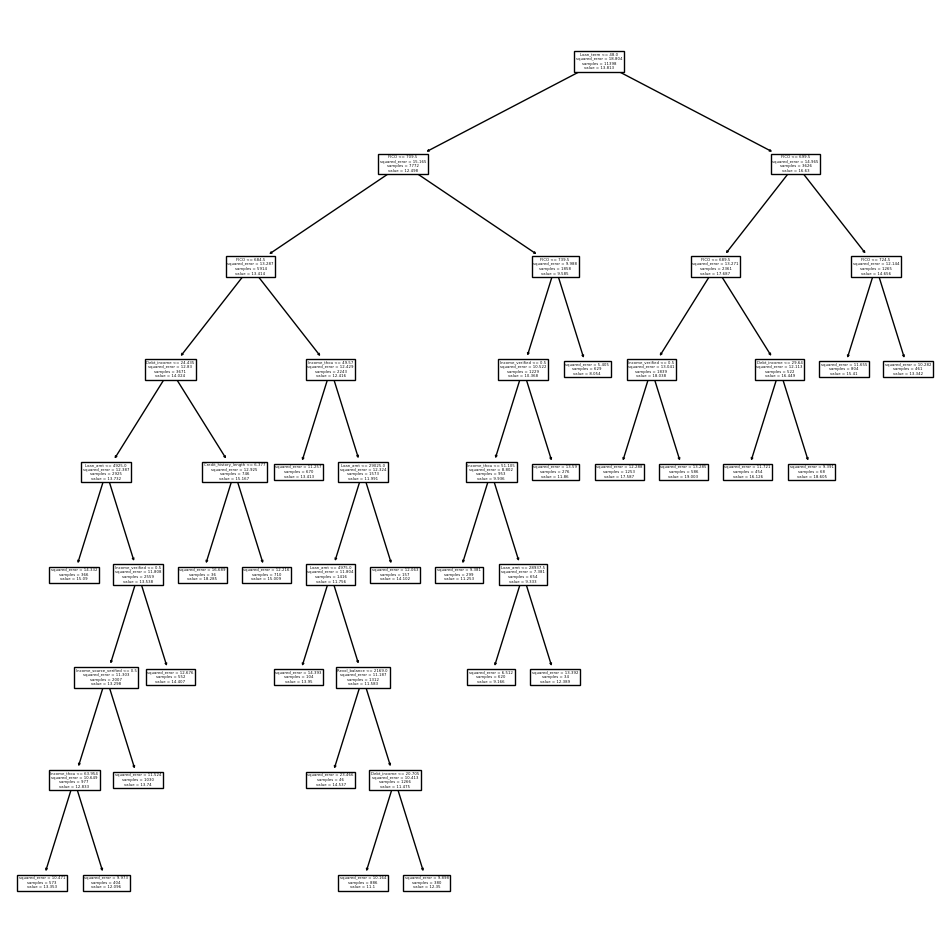

In [10]:
# plot the tree after pruning
ax = subplots(figsize=(12,12))[1] 
feature_names = list(X_train.columns)

plot_tree(best_, 
          feature_names=feature_names, 
          ax=ax);

### Bagging

##### Bagging significantly decreases test MSE and have produced the lowest test MSE so far

In [28]:
# define a bagging
bag = RF(max_features=X_train.shape[1], 
                random_state=0)

# Cross-validation to find n_estimator
param_grid = {
    'n_estimators': range(100, 401, 100)
}

bag_loan_rate = skm.GridSearchCV(bag, param_grid, cv=5)

# refit and print test MSE
bag_loan_rate.fit(X_train, y_train)
y_hat_bag = bag_loan_rate.predict(X_test)
MSE_bagging = np.mean((y_test - y_hat_bag)**2)

print(f'Test MSE from bagging is: {MSE_bagging}')

Test MSE from bagging is: 9.90293671900592


In [29]:
print(f'n_estimators = {bag_loan_rate.best_estimator_.n_estimators}')

n_estimators = 400


### Random Forest

##### We follow the convention and take square root of the number of available features for random forests. Random forests does a better job the bagging and have achieved a test MSE lower than 10

In [17]:
# Cross-validation to find best n_estimator

param_grid = {
    'n_estimators': range(100, 501, 100)
}
    
RF_loan_rate = skm.GridSearchCV(RF(max_features='sqrt', random_state=0), param_grid, cv=5)

# refit and print test MSE
RF_loan_rate.fit(X_train, y_train)
y_hat_RF = RF_loan_rate.predict(X_test) 
MSE_random_forests = np.mean((y_test - y_hat_RF)**2)
print(f'Test MSE from random forests is: {MSE_random_forests}')

Test MSE from random forests is: 9.619151262844644


In [31]:
print(f'n_estimators = {RF_loan_rate.best_estimator_.n_estimators}')

n_estimators = 500


In [13]:
RF_loan_rate = RF(max_features='sqrt', n_estimators=500)
RF_loan_rate.fit(X_train, y_train)

RandomForestRegressor(max_features='sqrt', n_estimators=500)

In [9]:
# Top 10 important factors
feature_imp = pd.DataFrame({'importance':RF_loan_rate.feature_importances_}, index=X_train.columns)
feature_imp.sort_values(by='importance', ascending=False)[0:10]

,importance
FICO,0.167997
Loan_term,0.166786
Revol_util,0.091049
Loan_amt,0.082807
Debt_income,0.080158
Revol_balance,0.076693
Income_thou,0.075718
Credit_history_length,0.072571
open_acc,0.050332
Income_verified,0.022010


### Gradient Boost

##### Because the sample size and the number of features are large, we select a high learning rate to control the time spent on boosting. We can further crossvalidate max_depth to improve the model.

In [32]:
# cross-validation to find max_depth
param_grid = {
    'max_depth': range(3, 11)
}

boost = GBR(n_estimators=1000,
                   learning_rate=0.1, 
                   random_state=0)
boost_loan_rate = skm.GridSearchCV(boost, param_grid, cv=5)
boost_loan_rate.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=GradientBoostingRegressor(n_estimators=1000,
                                                 random_state=0),
             param_grid={'max_depth': range(3, 11)})

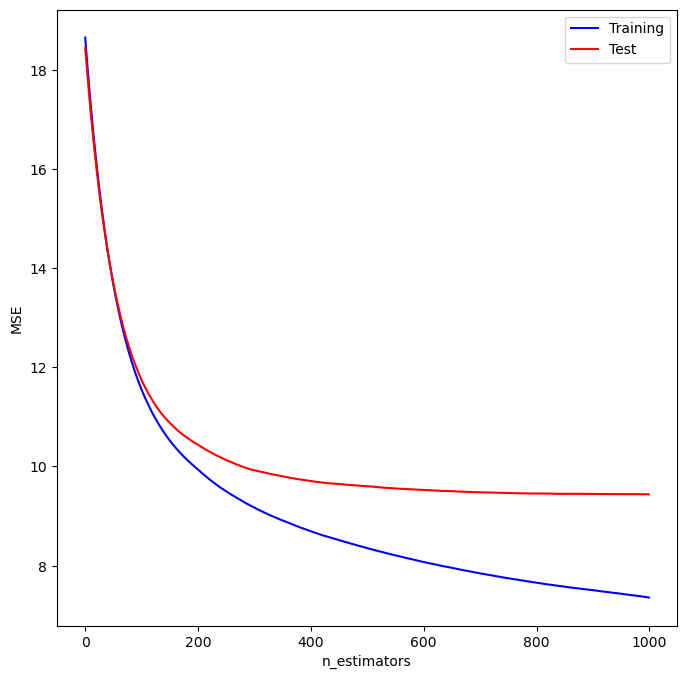

In [46]:
# graph train and test error with respect to n_estimators
test_error = np.zeros_like(boost_loan_rate.train_score_)

for idx, y_ in enumerate(boost_loan_rate.staged_predict(X_test)):
    test_error[idx] = np.mean((y_test - y_)**2)
    
plot_idx = np.arange(boost_loan_rate.train_score_.shape[0]) 
ax = subplots(figsize=(8,8))[1]
ax.plot(plot_idx,
        boost_loan_rate.train_score_, 'b',
        label='Training')

ax.plot(plot_idx, test_error ,
        'r',label='Test') 
ax.legend()
plt.xlabel('n_estimators')
plt.ylabel('MSE')
plt.show()


In [10]:
# refit the model
boost_loan_rate = GBR(n_estimators=1000,
                   learning_rate=0.01,
                   max_depth = 5,
                   random_state=0)
boost_loan_rate.fit(X_train,y_train)

GradientBoostingRegressor(learning_rate=0.01, max_depth=5, n_estimators=1000,
                          random_state=0)

In [11]:
# print test MSE
y_hat_boost = boost_loan_rate.predict(X_test)
MSE_boosted = np.mean((y_test - y_hat_boost)**2)
print(f'The test MSE from the boosted tree is: {MSE_boosted}')

The test MSE from the boosted tree is: 9.436690336340344


In [12]:
# Top 10 important factors
feature_imp = pd.DataFrame({'importance':boost_loan_rate.feature_importances_}, index=X_train.columns)
feature_imp.sort_values(by='importance', ascending=False)[0:10]

,importance
Loan_term,0.320960
FICO,0.299793
Loan_amt,0.080674
Revol_balance,0.055333
Income_thou,0.051159
Debt_income,0.049215
Credit_history_length,0.036227
Revol_util,0.035752
Income_verified,0.026139
open_acc,0.015096


##### Because of the large sample size and the number of features, it takes an extended amount of time to perform gridsearchcv and find the optimal configuration for parameters such as max depth and sample-split. However, the boosted tree still gave us the best model among other choices with a test MSE of 9.44.